In [1]:
!pip install git+https://github.com/ElArkk/jax-unirep.git --upgrade
!pip install biopython
!pip install seaborn

  Cloning https://github.com/ElArkk/jax-unirep.git to /tmp/pip-req-build-b4zvvb1r
  Running command git clone -q https://github.com/ElArkk/jax-unirep.git /tmp/pip-req-build-b4zvvb1r
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for jax-unirep: filename=jax_unirep-0.1-cp36-none-any.whl size=67745978 sha256=4d5cdf3e1da20cb8010b6b485f1002223fb93ef6001a98403a541bb843193bc8
  Stored in directory: /tmp/pip-ephem-wheel-cache-5ahkoi0r/wheels/08/4d/ac/6e75862c118d1ad82122f410859524b20190ce7a821b76ffcd
Successfully built jax-unirep
  Found existing installation: jax-unirep 0.1
    Uninstalling jax-unirep-0.1:
      Successfully uninstalled jax-unirep-0.1


In [2]:
from jax_unirep import get_reps, fit
from jax_unirep.utils import load_params_1900
from Bio import SeqIO
import pandas as pd
import glob
import os
from pathlib import Path
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import RidgeCV

import warnings
warnings.filterwarnings('ignore') 

import matplotlib.pyplot as plt
import seaborn as sns
import feather
import random



In [3]:
# read FASTA file:
# input: file name
# output: names and sequences in the file as an array of dim-2 arrays [name, sequence].
def read_fasta(name):
    fasta_seqs = SeqIO.parse(open(name + '.fasta.txt'),'fasta')
    data = []
    for fasta in fasta_seqs:
        data.append([fasta.id, str(fasta.seq).strip()])
    
    return data

# read sequence text file:
# input: file name
# output: names and sequences in the file as an array of dim-2 arrays [name, sequence].
def read_labeled_data(name):
    seqs = np.loadtxt(name + '_seqs.txt', dtype='str')
    
    fitnesses = np.loadtxt(name + '_fitness.txt')
    data = []
    for seq, fitness in zip(seqs, fitnesses):
        data.append([str(seq).strip(), fitness])
    
    return data

# save represented dataframe of features as feather
def save_reps(df, path):
  feather.write_dataframe(df, path + '.feather')
  print(path + '.feather', 'saved!')


# read represented dataframe of features as feather
def read_reps(path):
  return feather.read_dataframe(path + '.feather')


aa_to_int = {
  'M':1,
  'R':2,
  'H':3,
  'K':4,
  'D':5,
  'E':6,
  'S':7,
  'T':8,
  'N':9,
  'Q':10,
  'C':11,
  'U':12,
  'G':13,
  'P':14,
  'A':15,
  'V':16,
  'I':17,
  'F':18,
  'Y':19,
  'W':20,
  'L':21,
  'O':22, #Pyrrolysine
  'X':23, # Unknown
  'Z':23, # Glutamic acid or GLutamine
  'B':23, # Asparagine or aspartic acid
  'J':23, # Leucine or isoleucine
  'start':24,
  'stop':25,
}


def get_int_to_aa():
  return {value:key for key, value in aa_to_int.items()}


def _one_hot(x, k, dtype=np.float32):
  return np.array(x[:, None] == np.arange(k))


def aa_seq_to_int(s):
  """Return the int sequence as a list for a given string of amino acids."""
  # Make sure only valid aa's are passed
  if not set(s).issubset(set(aa_to_int.keys())):
    raise ValueError(
      f"Unsupported character(s) in sequence found:"
      f" {set(s).difference(set(aa_to_int.keys()))}"
    )

  return [aa_to_int[a] for a in s]


def aa_seq_to_onehot(seq):
  return 1*np.equal(np.array(aa_seq_to_int(seq))[:,None], np.arange(21)).flatten()
  

def multi_onehot(seqs):
  return np.stack([aa_seq_to_onehot(s) for s in seqs.tolist()])


def confusion_matrix_loss(Y_test,Y_preds_test):

  N = len(Y_test)
  Y_rank_matrix = np.zeros((N,N))
  Y_preds_rank_matrix = np.zeros((N,N))
  for i in range(N):
    for j in range(N):

      if Y_test[i] > Y_test[j]:
        Y_rank_matrix[i,j] = 1
      elif Y_test[i] <= Y_test[j]:
        Y_rank_matrix[i,j] = 0
      if Y_preds_test[i] > Y_preds_test[j]:
        Y_preds_rank_matrix[i,j] = 1
      elif Y_preds_test[i] <= Y_preds_test[j]:
        Y_preds_rank_matrix[i,j] = 0
  confusion_matrix = ~(Y_preds_rank_matrix == Y_rank_matrix)

  loss = np.sum(confusion_matrix)/confusion_matrix.size

  return loss

# Load the functions and utilities needed to simulate DE

In [4]:

def get_top_model(df, alpha, train_batch_size):

  rand_state_num = 42

  np.random.seed(rand_state_num)

  rndperm = np.random.permutation(df.shape[0])

  X_train = df.loc[rndperm[:train_batch_size], df.columns[2:]]
  Y_train = df.loc[rndperm[:train_batch_size], "fitness"]

  kfold = KFold(n_splits=10, random_state=rand_state_num, shuffle=True)

  return RidgeCV(alphas=alpha, cv=kfold).fit(X_train, Y_train)

def init_by_rep(df, alpha_val, N, param_file):

  if param_file == None:
    params = load_params_1900(None)
    DE_model = get_top_model(df, [alpha_val], N) # choose unirep representation, alpha=1e-3, and 96 training mutants


  else: # if we want to use an evotuned representation:
    params = load_params_1900(param_file)
    DE_model = get_top_model(df, [alpha_val], N) # choose eunirep representation, alpha=1e-3, and 96 training mutants

  return params, DE_model


def mutate_sequence(seq,m,prev_mut_loc): # produce a mutant sequence (integer representation), given an initial sequence and the number of mutations to introduce ("m")

  for i in range(m): #iterate through number of mutations to add
    rand_loc = random.randint(prev_mut_loc-8,prev_mut_loc+8) # find random position to mutate
    while (rand_loc <=0) or (rand_loc >= len(seq)):
      rand_loc = random.randint(prev_mut_loc-8,prev_mut_loc+8)

    rand_aa = random.randint(1,21) # find random amino acid to mutate to
    seq = list(seq)
    seq[rand_loc] = get_int_to_aa()[rand_aa] # update sequence to have new amino acid at randomely chosen position
    seq = ''.join(seq)


  return seq,rand_loc # output the randomely mutated sequence

def directed_evolution(s_wt,num_iterations,T,Model, params): # input = (wild-type sequence, number of mutation iterations, "temperature")		


  s_traj = [] # initialize an array to keep records of the protein sequences for this trajectory
  y_traj = [] # initialize an array to keep records of the fitness scores for this trajectory


  mut_loc_seed = random.randint(0,len(s_wt)) # randomely choose the location of the first mutation in the trajectory
  s,new_mut_loc = mutate_sequence(s_wt, (np.random.poisson(2) + 1),mut_loc_seed) # initial mutant sequence for this trajectory, with m = Poisson(2)+1 mutations

  x,_,_ = get_reps([s],params=params)# eUniRep representation of the initial mutant sequence for this trajectory

  y = Model.predict(x) # predicted fitness score for the initial mutant sequence for this trajectory


  # iterate through the trial mutation steps for the directed evolution trajectory
  for i in range(num_iterations):
    mu = np.random.uniform(1,2.5) # "mu" parameter for poisson function: used to control how many mutations to introduce
    m = np.random.poisson(mu-1) + 1 # how many random mutations to apply to current sequence

    s_new,new_mut_loc = mutate_sequence(s, m, new_mut_loc) # new trial sequence, produced from "m" random mutations

    x_new,_,_ = get_reps([s_new],params=params)

    y_new = Model.predict(x_new) # new fitness value for trial sequence

    p = min(1,np.exp((y_new-y)/T)) # probability function for trial sequence
    rand_var = random.random()

    if rand_var < p: # metropolis-Hastings update selection criterion
      print(str(new_mut_loc+1)+" "+s[new_mut_loc]+"->"+s_new[new_mut_loc])
      s, y = s_new, y_new # if criteria is met, update sequence and corresponding fitness

    s_traj.append(s) # update the sequence trajectory records for this iteration of mutagenesis
    y_traj.append(y) # update the fitness trajectory records for this iteration of mutagenesis


  return s_traj, y_traj # output = (sequence record for trajectory, fitness score recorf for trajectory)


def run_DE_trajectories(s_wt, Model, T, num_iterations, num_trajectories, DE_record_folder,params,save=False):

  s_records = [] # initialize list of sequence records
  y_records = [] # initialize list of fitness score records

  for i in range(num_trajectories): #iterate through however many mutation trajectories we want to sample
    s_traj, y_traj = directed_evolution(s_wt,num_iterations,T,Model,params) # call the directed evolution function, outputting the trajectory sequence and fitness score records

    s_records.append(s_traj) # update the sequence trajectory records for this full mutagenesis trajectory
    y_records.append(y_traj) # update the fitness trajectory records for this full mutagenesis trajectory

    if save==True:
      # iteration_path = directory_path+"DE_records/"
      np.savetxt(DE_record_folder + "/trajectory"+str(i)+"_seqs.txt", np.array(s_traj),fmt="%s")   # save sequence records for trajectory-i
      np.savetxt(DE_record_folder + "/trajectory"+str(i)+"_fitness.txt", np.array(y_traj))   # save fitness records for trajecroty-i
    print("finished trajectory #",i)

  s_records = np.array(s_records)
  y_records = np.array(y_records)

  plt.clf()
  fig = plt.figure(figsize=(10,6))
  plt.plot(np.transpose(y_records[:,:,0])) # plot the changes in fitness for all sampled trajectories
  plt.ylabel('Predicted Fitness')
  plt.xlabel('Mutation Trial Steps')
  plt.show() # show the plot :)

  return s_records, y_records

## TEM-1 beta-lactamase example:

## Mount google drive, Load datasets and parameters:

In [5]:
from google.colab import drive
drive.mount('/content/drive/')
directory_path = '/content/drive/My Drive/Colab Notebooks/UniRep/directed-evo/tutorial_files/'


seqs_df = pd.DataFrame(read_labeled_data(directory_path+'TEM1'), columns = ['sequence', 'fitness'])
df = read_reps(directory_path + 'TEM1_epoch1')
param_file = directory_path + 'TEM1_epoch1_weights'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#### Choose desired alpha value, representatation type, and initialize random state

In [6]:
alpha = 1e-2

BATCH_SIZE = 85

rand_state_num = 42

#### Pre-compute everything we will need for checking model and simulating mutagenesis

In [7]:
np.random.seed(rand_state_num)
rndperm = np.random.permutation(df.shape[0])


TRAIN_BATCH_SIZE = int(BATCH_SIZE*0.8)
HOLDOUT_BATCH_SIZE = int(BATCH_SIZE*0.2)

training_df = df.iloc[rndperm[:TRAIN_BATCH_SIZE],:]
                          
testing_df = df.iloc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE],:]

params, DE_model = init_by_rep(df, alpha, TRAIN_BATCH_SIZE, param_file)


### Make a plot to check how well the top model will perform

Train set ranking error:  0.10532006920415225
Test set ranking error:  0.31141868512110726


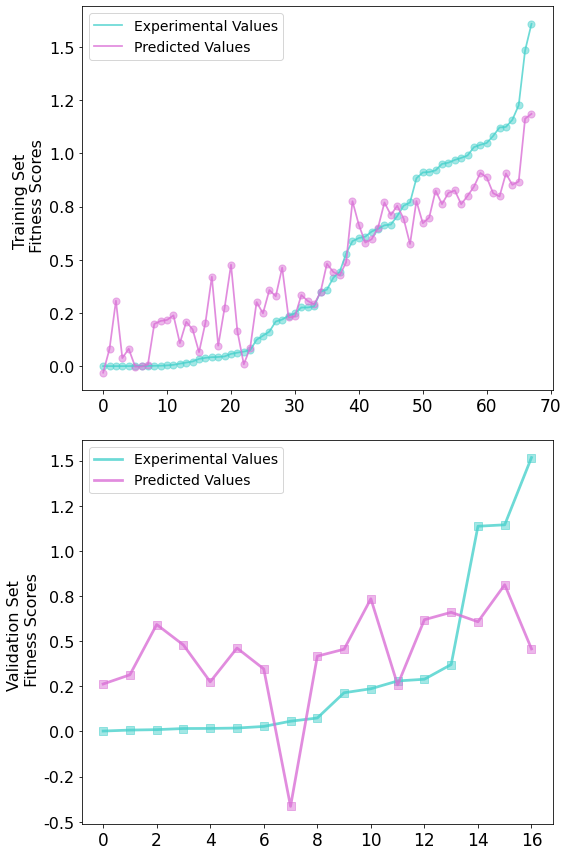

In [8]:


X_train = training_df.loc[:, training_df.columns[2:]]
Y_train = training_df.loc[:, "fitness"]
X_test = testing_df.loc[:, training_df.columns[2:]]
Y_test = testing_df.loc[:, "fitness"]


Y_train_preds = DE_model.predict(X_train)
Y_test_preds = DE_model.predict(X_test)

print("Train set ranking error: ", confusion_matrix_loss(np.array(Y_train),Y_train_preds))
print("Test set ranking error: ", confusion_matrix_loss(np.array(Y_test),Y_test_preds))


fig = plt.figure(figsize=(8,12))

ax1 = fig.add_subplot(2,1,1)
ax1.plot(np.arange(len(Y_train)), np.array(Y_train)[np.argsort(Y_train)],color='mediumturquoise',linewidth=1.75, alpha=0.8)
ax1.plot(np.arange(len(Y_train)), np.array(Y_train_preds)[np.argsort(Y_train)],color='orchid',linewidth=1.75, alpha=0.8)


ax1.scatter(np.arange(len(Y_train)), np.array(Y_train)[np.argsort(Y_train)],color='mediumturquoise',s=50, alpha=0.5)
ax1.scatter(np.arange(len(Y_train)), np.array(Y_train_preds)[np.argsort(Y_train)],color='orchid',s=50, alpha=0.5)


ax2 = fig.add_subplot(2,1,2)
ax2.plot(np.arange(len(Y_test)), np.array(Y_test)[np.argsort(Y_test)],color='mediumturquoise',linewidth=2.75, alpha=0.8)
ax2.plot(np.arange(len(Y_test)), np.array(Y_test_preds)[np.argsort(Y_test)],color='orchid',linewidth=2.75, alpha=0.8)

ax2.scatter(np.arange(len(Y_test)), np.array(Y_test)[np.argsort(Y_test)],color='mediumturquoise',s=50, alpha=0.5,marker="s")
ax2.scatter(np.arange(len(Y_test)), np.array(Y_test_preds)[np.argsort(Y_test)],color='orchid',s=50, alpha=0.5,marker="s")




ax1.set_ylabel("Training Set \n Fitness Scores",size=16)
ax2.set_ylabel("Validation Set \n Fitness Scores",size=16)


ax1.set_yticklabels(np.round(ax1.get_yticks(),1),fontsize=16)
ax2.set_yticklabels(np.round(ax2.get_yticks(),1),fontsize=16)



ax1.set_xticklabels(ax1.get_xticks().astype(int),fontsize=17)
ax2.set_xticklabels(ax2.get_xticks().astype(int),fontsize=17)


fig.tight_layout(w_pad=2.5, h_pad=2.5)

ax1.legend(['Experimental Values','Predicted Values'],fontsize=14)
ax2.legend(['Experimental Values','Predicted Values'],fontsize=14)


plt.show()






#  Simulation of directed evolution

### Define simulation parameters, protein sequence, and record file-path

In [9]:
# define the wild-type sequence
s_wt = "MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW"


DE_record_folder = directory_path + "TEM1_DE_tutorial_records" # assign project name for the simulation

T = 0.01 # "temperature" parameter: determines sensitivity of Metropolis-Hastings acceptance criteria
num_iterations = 25 # how many subsequent mutation trials per simulated evolution trajectory
num_trajectories = 5 # how many separate evolution trajectories to run

## Now we can run the simulation

142 G->Q
136 L->G
144 K->W
151 H->M
136 G->P
153 M->Y
finished trajectory # 0
97 Q->S
107 T->C
110 H->K
121 C->A
131 T->T
finished trajectory # 1
155 D->R
163 W->V
157 V->T
167 L->C
174 D->W
184 M->E
169 E->N
178 T->V
179 T->V
finished trajectory # 2
245 E->H
237 E->S
238 R->N
230 A->P
233 S->F
finished trajectory # 3
104 S->H
128 S->S
132 A->D
144 K->T
144 T->H
164 E->W
166 E->E
finished trajectory # 4


<Figure size 432x288 with 0 Axes>

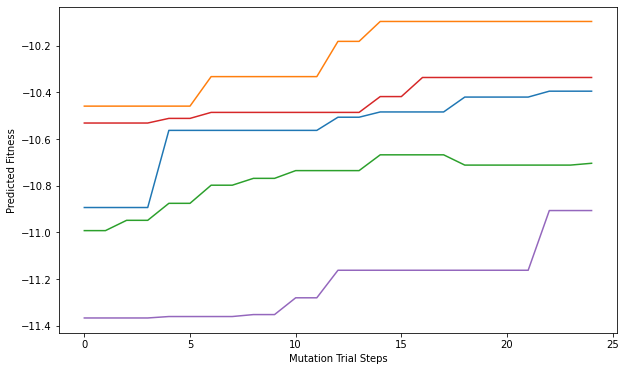

In [10]:
s_records, y_records = run_DE_trajectories(s_wt, DE_model, T, num_iterations, num_trajectories, DE_record_folder, params ,save=True)

# We can also re-load the data from our previous simulation if needed for subsequent analyses


## define the previous test's info:

In [11]:
DE_record_folder = directory_path + "TEM1_DE_tutorial_records" # assign project name for the simulation
num_trajectories = 5

## plot the mutation trajectories from the previous test

<Figure size 432x288 with 0 Axes>

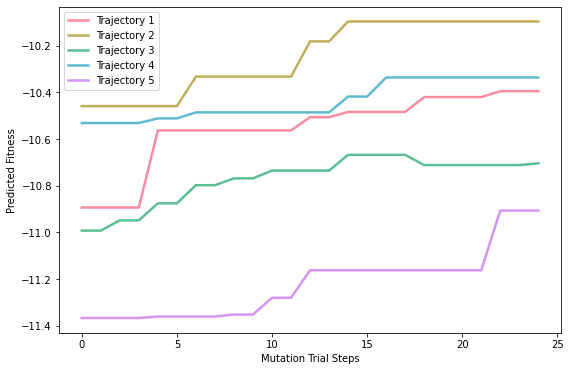

In [12]:
pal = sns.color_palette("husl", num_trajectories)
plt.clf()
fig = plt.figure(figsize=(9,6))
label_list = []
color_idx = np.linspace(0, 1, num_trajectories)
for i,i_color in zip(list(np.arange(num_trajectories)),pal):
  traj_name = DE_record_folder+"/trajectory"+str(i)
  seqs = np.loadtxt(traj_name + "_seqs.txt",dtype=str)
  fitness = np.loadtxt(traj_name + "_fitness.txt")
  plt.plot(fitness,color=i_color,linewidth=2.5,alpha=0.8)
  label_list.append("Trajectory "+str(i+1))
plt.ylabel("Predicted Fitness")
plt.xlabel('Mutation Trial Steps')
plt.legend(label_list)


plt.show()



## We can also print the sequences generated in previous simulations:

In [13]:
for i in range(num_trajectories):
  print("Trajectory " + str(i+1) +" sequences:")
  seqs = np.loadtxt(DE_record_folder+"/trajectory"+str(1) + "_seqs.txt",dtype=str)
  print(seqs)
  print(" ")

Trajectory 1 sequences:
['MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEILGRRDEYSSNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW'
 'MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEILGRRDEYSSNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW'
 'MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEILGRRDEYSSNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW'
 'MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEILGRRDEYSSNDLVEYS